The ReturnFlows component will eventually handle both the withdrawals and return flows between counties and gauges.  It provides the link between `gauges`, which are nodes in the Water Network, and `canals`, which are the bipartite graph edges that connect `gauges` and `counties`.

Currently the ReturnFlows component does not handle return flows.  It does, however, handle withdrawals.

In [1]:
using Mimi

@defcomp ReturnFlows begin
    canals = Index()

    # How much to send from each gauge to each county
    withdrawals = Parameter(index=[canals, time])

    # For now, exact copy of withdrawals; later, the amount actually provided for each withdrawal?
    copy_withdrawals = Variable(index=[canals, time])
    # Water removed from gauge
    removed = Variable(index=[gauges, time])
end

ReturnFlows

The ReturnFlows component takes as its input the withdrawals specified on a per-canal basis.

In [2]:
function timestep(c::ReturnFlows, tt::Int)
    v = c.Variables
    p = c.Parameters
    d = c.Dimensions

    for gg in 1:numgauges
        v.removed[gg, tt] = 0.
    end

    for pp in 1:nrow(draws)
        v.copy_withdrawals[pp, tt] = p.withdrawals[pp, tt]
        if p.withdrawals[pp, tt] > 0
            gaugeid = draws[pp, :gaugeid]
            gg = vertex_index(wateridverts[gaugeid])
            if (gg == 0)
                println("Missing $gaugeid")
            else
                v.removed[gg, tt] += p.withdrawals[pp, tt]
            end
        end
    end
end

timestep (generic function with 3 methods)

The `timestep` sums up all water removed from each gauge.

It would be nice for the ReturnFlows component to take `withdrawals` as "requested withdrawals", and then to produce a variable describing "statisfied withdrawals", dependent on the availability of river flow at the gauges.  However, since ReturnFlows is run before the WaterNetwork, the full propogation of withdrawals and additions is unknown.

The simulation resolves this by applying additions and withdrawals simultaneously all throughout the water network.  However, this logic is more complicated and difficult to debug.

Future tasks:
* Check that in simulation mode, WaterNetwork `added` is incremental, since this specifies that `removed` is incremental.
* Extract the `gauge x canal` portion of the WaterNetwork's `grad_waternetwork_outflows_withdrawals` to this component.
* Handle actual return flows.

## Spatially varying return flows

Return flows vary according to irrigation methods. We combine the runoff fractions from [Grafton et al. (2018)](https://science.sciencemag.org/content/361/6404/748) with records of irrigation method usage from [USDA](https://www.nass.usda.gov/Publications/AgCensus/2012/Online_Resources/Farm_and_Ranch_Irrigation_Survey/fris13_2_028_028.pdf).

Since USDA only provides these values on a state-by-state basis, we use soil characteristics to further resolve return flow fractions. Our first step is to calculate the return flow fractions for each irrigation method, using soil properties. To do this, we apply the method described by [Dewandel et al. (2007)](https://onlinelibrary.wiley.com/doi/abs/10.1002/hyp.6738). For a given irrigation quantity, $Q$, we assume a water balance according to:
$$Q = (ET) T + (RF) T + (X) T$$

where $ET$ is the evapotranspiration; $RF$ is the return flow; $X$ encompasses unobserved features, including lateral seepage, runoff, and change in the water stock; and $T$ is the period for the water to be absorbed. For $ET$, we use GeoNetwork calculations based on the FAO Penman-Monteith method. $RF$ is calculated based on the infiltration rate, using hydraulic conductivity at saturation, using soil texture data from the HWSD (Nachtergaele et al. 2010), according to the approach in Saxton et al. (1986). We arrange this to describe the return flow fraction:
$$\frac{RF + Y}{ET + RF + X}$$
and finally estimate the values of $X$ and $Y$ so that the range of values observed across the US matches the bounds provided by Grafton et al. The results are shown below.

| Irrigation method | Reported bounds | $Y$ | $X$ |
| ----------------- |:---------------:| --- | --- |
| Gravity systems | 15 - 50% | 506 | 3539 |
| Sprinkler systems | 5 - 15% | 942 | 20634 |
| Low-flow methods | 0 - 10% | -11 | 22690 |

Then, for each state we take a different weighted average for each state, depending on its share of each method from the USDA.

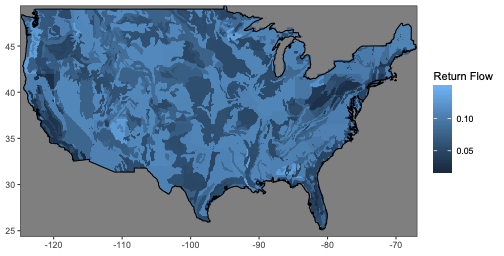